In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

### Load Frames

In [2]:
def load_video_frames(path, color=False):
    vid = cv2.VideoCapture(path)
    frames = []
    while vid.isOpened():
        ret, frame = vid.read()
        if not ret:
            break

        conversion = cv2.COLOR_BGR2RGB if color else cv2.COLOR_BGR2GRAY
        frame = cv2.cvtColor(frame, conversion)
        frames.append(frame)
    
    vid.release()
    return np.array(frames)

color_frames = load_video_frames("cropped_cat_video.mp4", color=True)
frames = load_video_frames("cropped_cat_video.mp4")


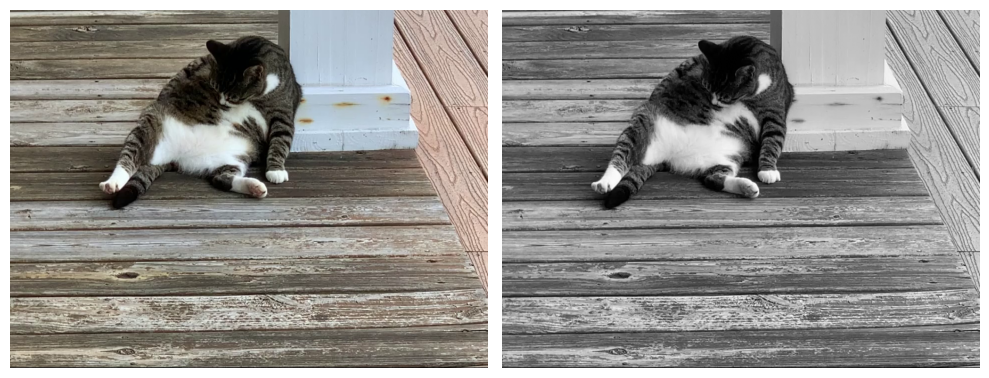

In [3]:
def show_frames(*frames):
    for i, f in enumerate(frames):
        plt.subplot(np.ceil(len(frames) / 2).astype(int), 2, i+1)
        plt.imshow(f, cmap="gray")
        plt.axis("off")
    plt.gcf().set_figwidth(10)
    plt.gcf().set_figheight(7.5)
    plt.tight_layout()
    plt.show()

show_frames(color_frames[0], frames[0])

### Image Gradient

In [4]:
def row(vector):
    return vector.reshape(1, -1)

def col(vector):
    return vector.reshape(-1, 1)

# function to convert sigma <--> h for kernels
def truncate(sigma=None, h=None):
    assert (sigma is not None) or (h is not None), "Must provide either sigma or h"
    if sigma is None:
        sigma = h / 2.5
    elif h is None:
        h = np.ceil(2.5 * sigma)
    return sigma, h
    

def gaussian_kernel(sigma=None, h=None):
    sigma, h = truncate(sigma, h)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front and normalize after
    kernel = np.exp(-0.5*(x / sigma)**2)
    norm_factor = np.convolve(np.ones_like(kernel), kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel


def deriv_kernel(sigma=None, h=None):
    # get derivative of gaussian
    sigma, h = truncate(sigma, h)
    x = np.arange(-h, h + 1, 1)
    # ignore constant in front because will rescale anyways
    kernel = -x * np.exp(-0.5*(x / sigma)**2)

    # normalize so derivative on a unit ramp is correct
    unit_ramp = x  # by coincidence, we already made a unit ramp of the correct shape
    norm_factor = np.convolve(unit_ramp, kernel, mode="valid")[0]
    kernel /= norm_factor

    # plt.plot(x, kernel)
    return kernel

In [103]:
from numpy.lib.stride_tricks import as_strided

# batch convolution from ChatGPT, with modifications

def batch_conv(images, kernel, mode="same"):
    """
    Perform 2D convolution on a batch of images using NumPy's stride tricks.
    
    Parameters:
    - images: np.ndarray of shape (N, H, W), batch of N images.
    - kernel: np.ndarray of shape (KH, KW), convolution kernel.
    - mode: str, "same" or "valid", default="same".
    
    Returns:
    - convolved: np.ndarray of shape (N, H_out, W_out).
    """
    B, H, W = images.shape
    KH, KW = kernel.shape

    if mode == "same":
        pad_h = (KH - 1) // 2
        pad_w = (KW - 1) // 2
        images = np.pad(images, ((0, 0), (pad_h, pad_h), (pad_w, pad_w)), mode="constant")
    elif mode == "valid":
        pad_h = pad_w = 0
    else:
        raise ValueError("Unsupported mode. Choose 'same' or 'valid'.")

    # Compute output dimensions
    H_out = H + 2 * pad_h - KH + 1
    W_out = W + 2 * pad_w - KW + 1
    new_shape = (B, H_out, W_out, KH, KW)

    # Compute strides
    new_strides = images.strides + images.strides[1:]

    # Create sliding window views of the input
    strided = as_strided(images.squeeze(), new_shape, new_strides)

    # Perform convolution via element-wise multiplication and summation
    # Remember to flip the kernel since this is convolution, not cross-correlation
    convolved = np.einsum("bhwkl,kl->bhw", strided, np.flip(kernel))

    return convolved


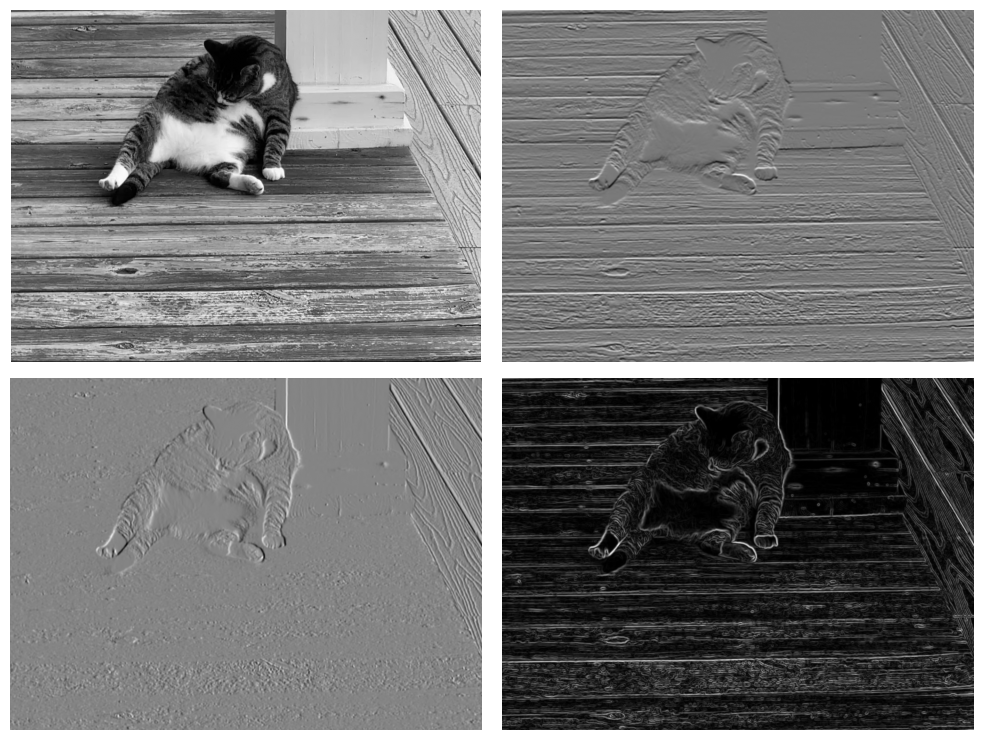

In [104]:
def image_gradient(frames, sigma=None, h=None):
    d = deriv_kernel(sigma, h)
    g = gaussian_kernel(sigma, h)
    # smooth in one direction and differentiate in the other
    vert_deriv = batch_conv(batch_conv(frames, col(d), mode="valid"), row(g), mode="valid")
    horiz_deriv = batch_conv(batch_conv(frames, row(d), mode="valid"), col(g), mode="valid")
    return np.stack((vert_deriv, horiz_deriv), axis=1)

grad = image_gradient(frames[:1], sigma=1.25)[0]
grad_mag = np.linalg.norm(grad, axis=0)
show_frames(frames[0], grad[0], grad[1], grad_mag)


### Features to Track

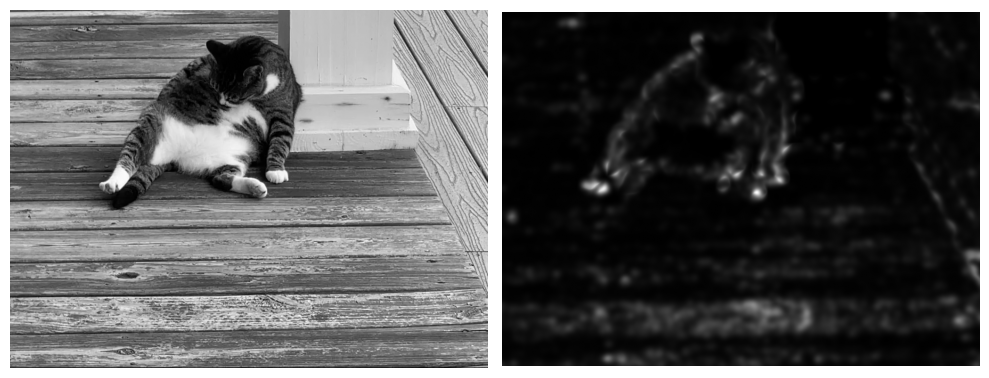

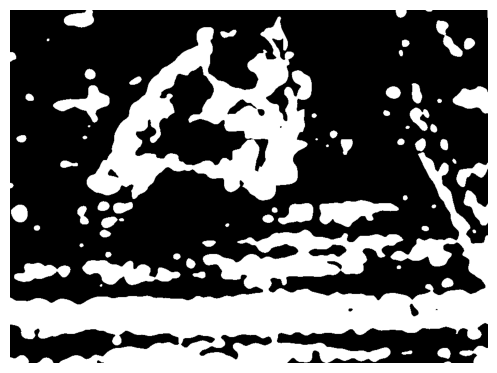

In [105]:
def get_matrix_A_elements(gradient, window_size):
    g_00 = gradient[0] ** 2
    g_01 = gradient[0] * gradient[1]
    g_11 = gradient[1] ** 2

    # convolve with window to get the 3 distinct elements of matrix A for each pixel
    # 3 not 4 because A is symmetric
    # do each element in two steps to exploit separability
    h = (window_size - 1) / 2
    w = gaussian_kernel(h=h)
    row_w = row(w)
    col_w = col(w)
    a_00 = convolve2d(convolve2d(g_00, row_w, "valid"), col_w, "valid")
    a_01 = convolve2d(convolve2d(g_01, row_w, "valid"), col_w, "valid")
    a_11 = convolve2d(convolve2d(g_11, row_w, "valid"), col_w, "valid")

    return a_00, a_01, a_11


def smaller_eigenvalues(frame, window_size=31):
    assert window_size % 2 == 1, "Window size should be an odd number"

    grad = image_gradient(np.array([frame]), sigma=1.25)[0]
    a_00, a_01, a_11 = get_matrix_A_elements(grad, window_size)

    # use quadratic formula to solve for smaller eigenvalue
    # get b and c coefs for quadratic formula, a is 1
    b = - (a_00 + a_11)
    c = a_00*a_11 - a_01**2
    discrim = np.sqrt(np.maximum(0., b**2 - 4*c))  # max with 0 in case floating point error gives us barely negative numbers
    smaller_eigen = (-b - discrim) / 2
    return smaller_eigen


min_e  = smaller_eigenvalues(frames[0])
show_frames(frames[0], min_e)
show_frames(min_e > 10)

0.27451395988464355
0.2877383232116699
0.4029097557067871
Found 20 features!


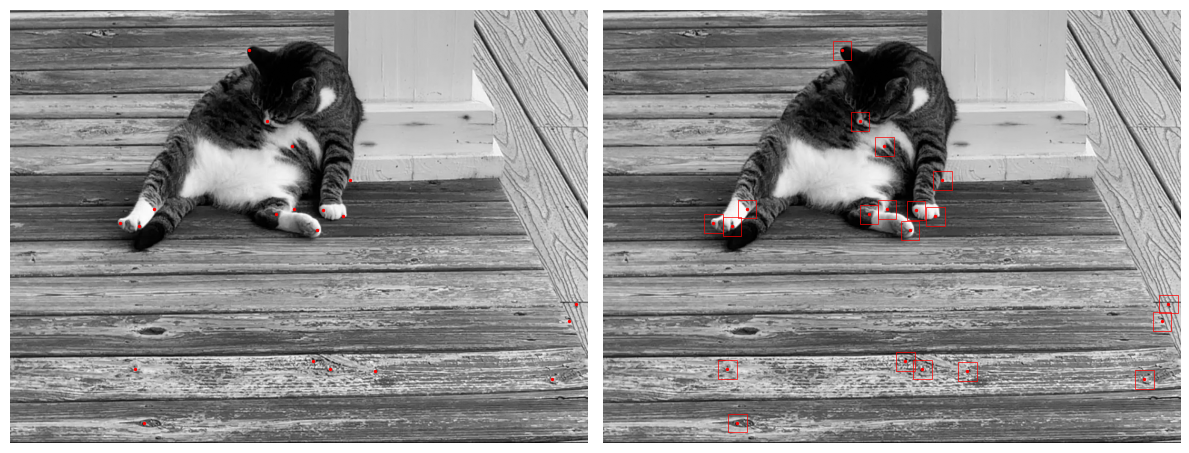

In [44]:
from matplotlib.patches import Rectangle
import time


def features_to_track(frame, max_n=200, window_size=31, radius=None, small_eig_threshold=10):
    assert window_size % 2 == 1, "Window size should be an odd number"
    t0 = time.time()

    if radius is None:
        radius = window_size
    small_eigs = smaller_eigenvalues(frame, window_size)

    print(time.time() - t0)

    # get indices of locations we have small eigs for
    # this is a smaller region than the image b/c we used valid convolutions
    offset = (frame.shape[0] - small_eigs.shape[0]) // 2
    r, c = np.indices(small_eigs.shape) + offset
    eigs_and_indices = np.dstack((small_eigs, r, c)).reshape(-1, 3)

    # remove pixels failing the small eigenvalue threshold
    meet_threshold = eigs_and_indices[:, 0] >= small_eig_threshold
    eigs_and_indices = eigs_and_indices[meet_threshold]

    # sort by eigenvalue
    sort_indices = np.argsort(-eigs_and_indices[:, 0])
    eigs_and_indices = eigs_and_indices[sort_indices]

    print(time.time() - t0)

    # use non-max suppression to choose features to track
    features = []
    for _ in range(max_n):
        if eigs_and_indices.shape[0] == 0:
            break
        pixel = eigs_and_indices[0, 1:]
        features.append(pixel)
        # remove pixels close to this feature
        sq_dist = np.sum((eigs_and_indices[:, 1:] - pixel)**2, axis=1)
        eigs_and_indices = eigs_and_indices[sq_dist > radius ** 2]

        # remove pixels in a square region around this feature - is a bit faster
        # deltas = np.abs(eigs_and_indices[:, 1:] - pixel)
        # keep_mask = (deltas[:,0] > radius) | (deltas[:,1] > radius)
        # eigs_and_indices = eigs_and_indices[keep_mask]

    print(time.time() - t0)

    return np.array(features)


def plot_features(frame, features, window_size):
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.axis("off")
        plt.imshow(frame, cmap="gray")
        plt.scatter(features[:, 1], features[:, 0], s=2, c="red")
    h = (window_size - 1) / 2
    for f in features:
        rect = Rectangle((f[1] - h, f[0] - h), window_size, window_size,
                        edgecolor="red", facecolor="none", linewidth=0.5)
        plt.gca().add_patch(rect)
    plt.gcf().set_figwidth(12)
    plt.tight_layout()


window_size = 31
features = features_to_track(frames[0], window_size=window_size, max_n=20)
print(f"Found {features.shape[0]} features!")
plot_features(frames[0], features, window_size)
plt.show()

In [131]:
s = set([1,2,3,4])
np.arange(20)[list(s)]

array([1, 2, 3, 4])

### Tracking

In [218]:
from scipy.ndimage import map_coordinates


def crop_margin(batch_imgs, margin):
    return batch_imgs[:, margin:-margin, margin:-margin]


def sample_image(frame, coords):
    # frame is shape H x W
    # coords are shape B x 2 x H x W
    coords = np.permute_dims(coords, (1, 0, 2, 3))
    return map_coordinates(frame, coords, order=2)


def LK(frame0, frame1, features, d0=None, window_size=31, min_step_size=0.001, max_iter=100, verbose=False):
    assert window_size % 2 == 1, "Window size should be an odd number"
    # convert from uint8 to floats so negative numbers don't misbehave
    frame0, frame1 = frame0.astype(float), frame1.astype(float)

    # TODO check if started outside image bounds

    if d0 is None:
        d0 = np.zeros_like(features)
    d = d0.copy()

    # define window indices and use them to get the pixel values of the frame0 window
    h = (window_size - 1) / 2
    margin = 4  # due to valid convolution when taking image gradient
    padded_shape = (window_size + 2*margin, window_size + 2*margin)
    window_indices = np.indices(padded_shape) - (h + margin)
    # duplicate for all features
    window_indices = np.expand_dims(window_indices, axis=0)
    window_indices = np.repeat(window_indices, features.shape[0], axis=0)

    # center on features
    window_indices = window_indices + np.expand_dims(features, (2, 3))
    # get pixel values in first frame
    i = sample_image(frame0, window_indices)

    # from now on, we will use window indices to refer to the frame1 window, update appropriately
    window_indices = window_indices + np.expand_dims(d, (2, 3))

    gaussian = gaussian_kernel(h=h)
    window_weights = col(gaussian) * row(gaussian)
    # add batch dim for broadcasting clarity
    window_weights = np.expand_dims(window_weights, axis=0)

    # iterate
    done = np.full(features.shape[0], False)
    for _ in range(max_iter):
        # filter for only the features we're not done with yet
        active_indices = np.arange(features.shape[0])[~done]
        if verbose:
            print("active indices", active_indices)

        # get pixel values of shifted window w margin
        j = sample_image(frame1, window_indices[active_indices])

        # get gradient for all points in window
        grad = image_gradient(j, sigma=1.25)

        # use gradient to get batches of A and b
        A = np.zeros((active_indices.shape[0], 2, 2))
        A[:, 0, 0] = np.sum(np.square(grad[:, 0, :, :])
                            * window_weights, axis=(1, 2))
        A[:, 0, 1] = np.sum(grad[:, 0, :, :] *
                            grad[:, 1, :, :] * window_weights, axis=(1, 2))
        A[:, 1, 0] = A[:, 0, 1]
        A[:, 1, 1] = np.sum(np.square(grad[:, 1, :, :])
                            * window_weights, axis=(1, 2))

        b = np.zeros((active_indices.shape[0], 2, 1))
        diff = crop_margin(i[active_indices], margin) - crop_margin(j, margin)
        b[:, 0] = np.sum(grad[:, 0, :, :] * diff *
                         window_weights, axis=(1, 2)).reshape(-1, 1)
        b[:, 1] = np.sum(grad[:, 1, :, :] * diff *
                         window_weights, axis=(1, 2)).reshape(-1, 1)

        if verbose:
            print("A", A, "\n")
            print("b", b, "\n")

        # solve for the step
        step = np.linalg.solve(A, b).squeeze(axis=2)

        # accumulate the step into the total displacement d
        d[active_indices] = d[active_indices] + step
        # update window indices with the step
        window_indices[active_indices] = window_indices[active_indices] + \
            np.expand_dims(step, (2, 3))

        if verbose:
            print("d", d, "\nlast step size", np.linalg.norm(step, axis=1))
            print("")

        # check if we converged
        converged = np.linalg.norm(step, axis=1) < min_step_size
        done[active_indices[converged]] = True

        # check if we're lost, set displacement to nan if so
        too_big_d = np.linalg.norm(d[active_indices] - d0[active_indices], axis=1) > h
        d[active_indices[too_big_d]] = np.nan
        done[active_indices[too_big_d]] = True
        if verbose and np.any(too_big_d):
            print(f"Too big step for features {active_indices[too_big_d]}")
        # TODO check if left image g bounds

        if np.all(done):
            break

    if verbose:
        for k in range(features.shape[0]):
            show_frames(i[k], sample_image(frame1, window_indices)[k])

    return d


# print(features)
LK(frames[0], frames[1], features[:20], window_size=31)

array([[ 1.72871829,  1.92245752],
       [ 1.37490211,  2.41554066],
       [ 1.73387774,  1.74029589],
       [ 1.40489836,  1.86498754],
       [ 1.62964309,  1.68969423],
       [ 1.97404151,  1.54585012],
       [ 1.21963834,  2.37935996],
       [ 1.26836488,  2.33117769],
       [ 1.068085  ,  2.82291483],
       [-2.74828167,  2.16441942],
       [ 0.70742748,  1.29055533],
       [ 0.41566492,  1.79828928],
       [ 0.33606665,  1.34541314],
       [ 1.32388967,  1.1989867 ],
       [ 1.4861561 ,  2.10429699],
       [ 1.08397598,  1.29490418],
       [ 1.75374486,  0.67363244],
       [-6.57224372,  5.88771696],
       [ 1.58865334,  1.86809203],
       [ 1.05675543,  1.61495152]])

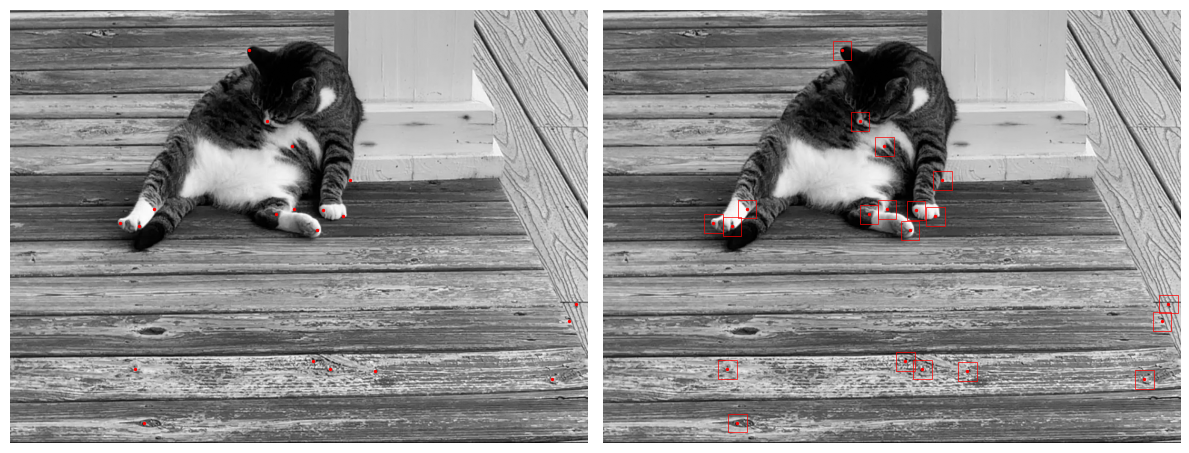

(20, 2)


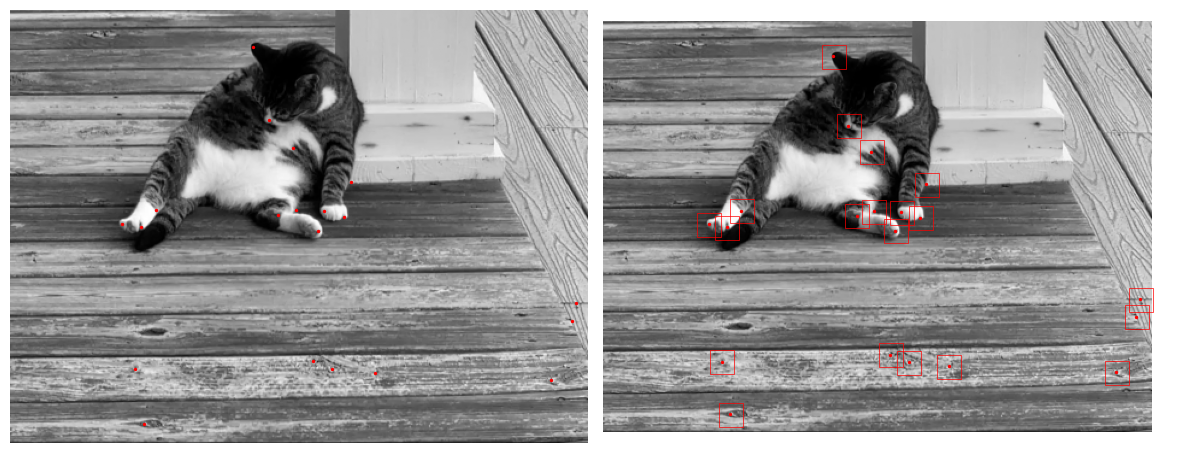

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)


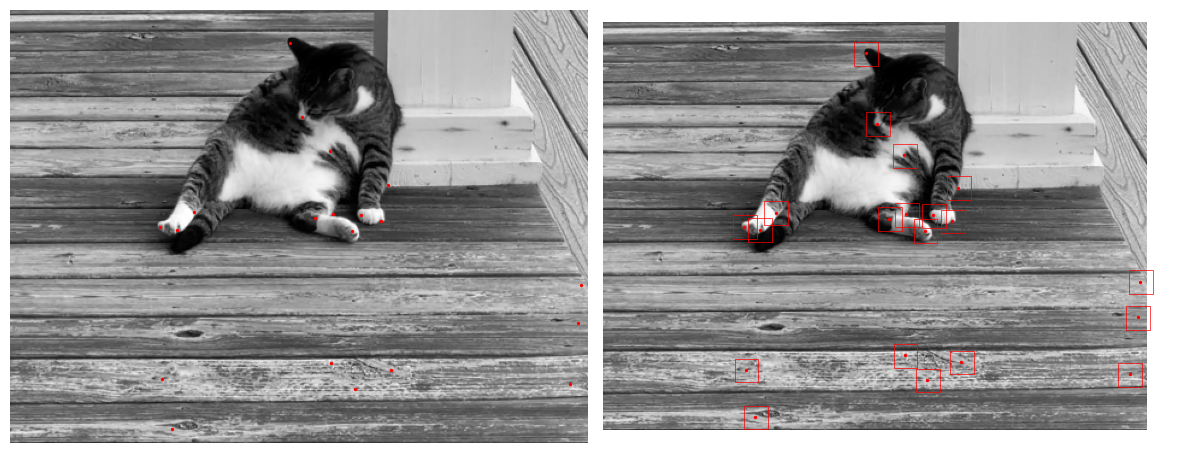

(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(20, 2)
(19, 2)


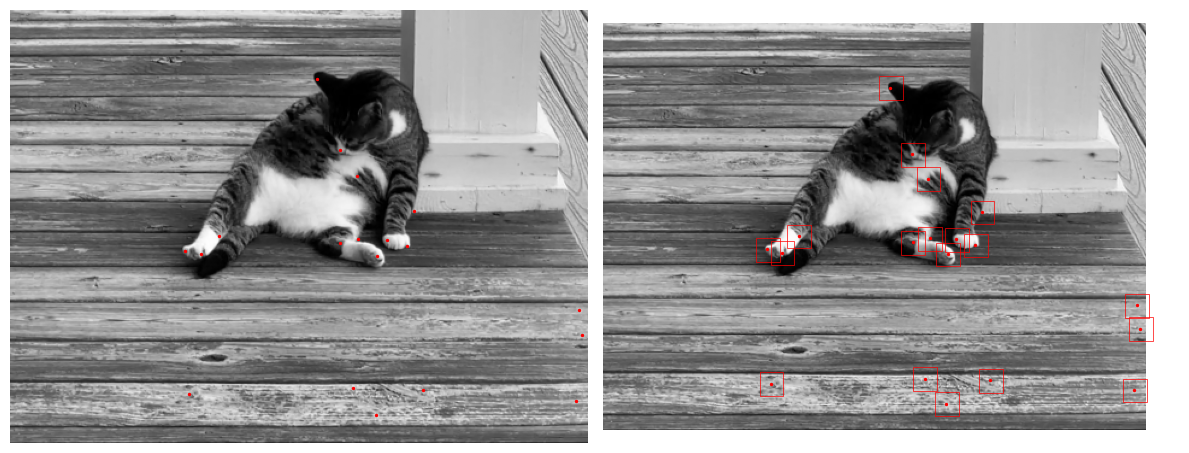

(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)


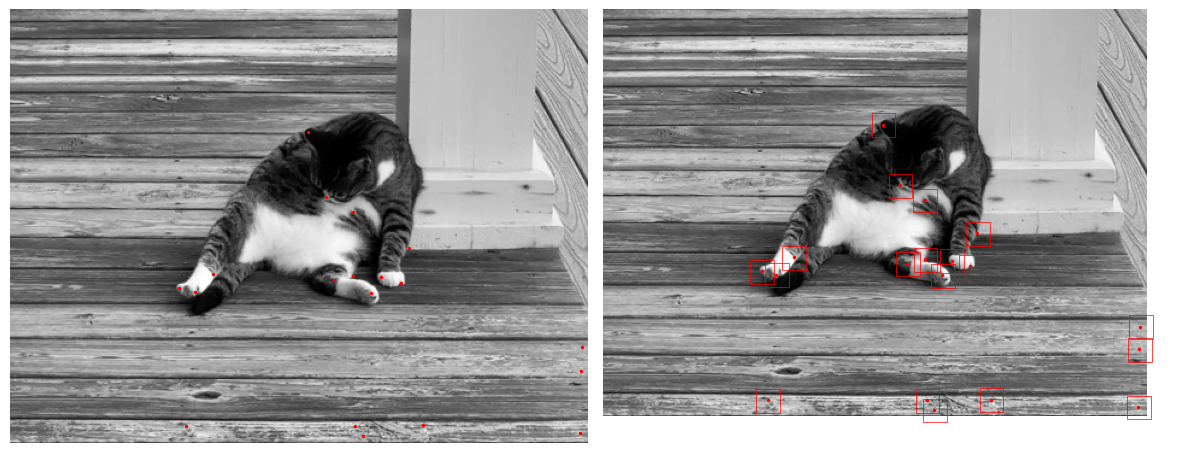

(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)
(19, 2)


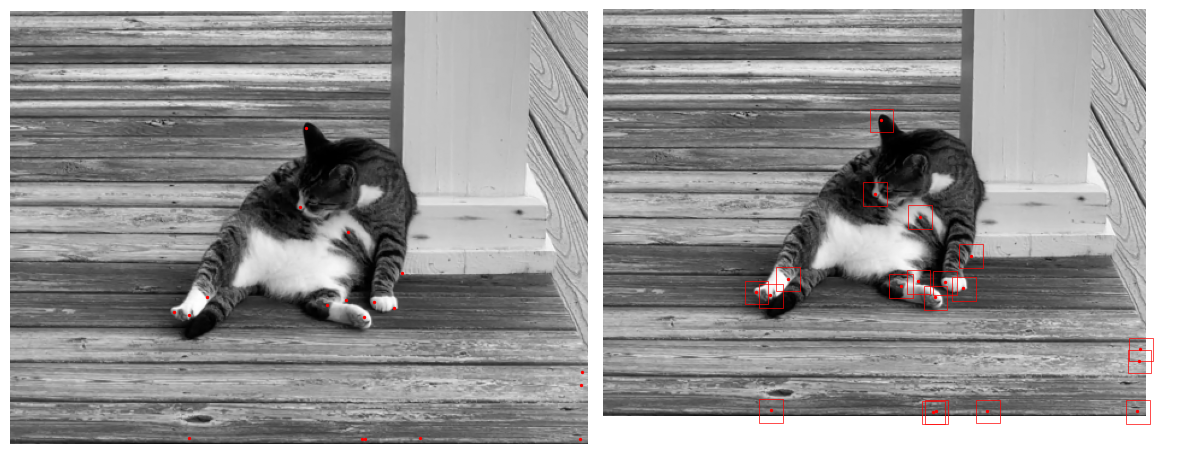

(19, 2)
(19, 2)
(19, 2)
(18, 2)
(18, 2)
(18, 2)
(18, 2)
(18, 2)
(18, 2)
(18, 2)
(18, 2)
(18, 2)
(17, 2)
(17, 2)
(17, 2)
(17, 2)
(17, 2)
(17, 2)
(15, 2)
(15, 2)


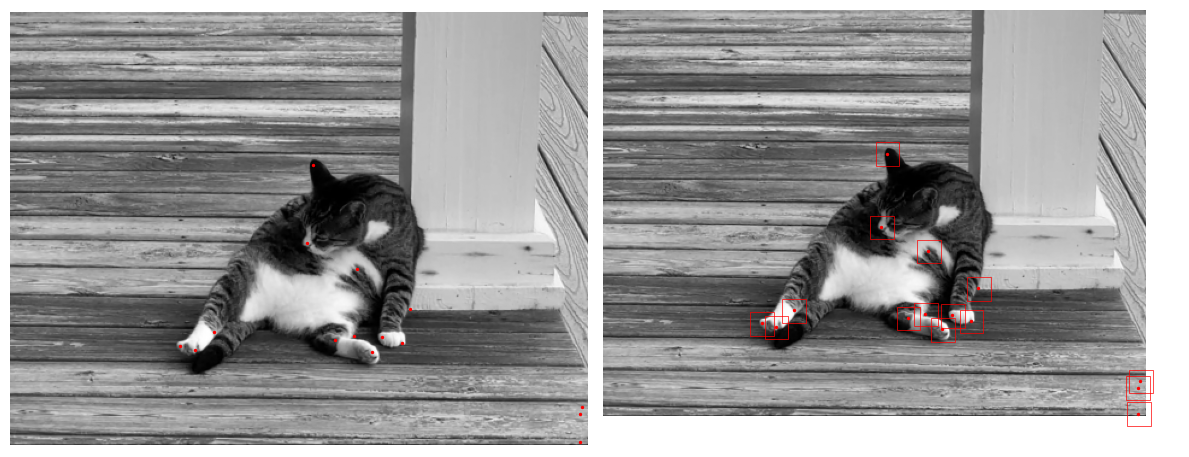

In [222]:
from skimage.transform import resize

def track_features(frame0, frame1, features, window_size=31, pyramid_levels=2):
    new_coords = []
    # for level in range(pyramid_levels):

    for feature in features:
        d = LK(frame0, frame1, feature, window_size=window_size)
        if not np.isnan(d[0]):
            new_coords.append(feature + d)
    return np.array(new_coords)

selected = features
plot_features(frames[0], selected, window_size=31)
plt.show()

window_size = 21
zoom_factor = 2

points = selected / zoom_factor
for i in range(101):
    small_shape = (frames[i].shape[0] // zoom_factor, frames[i].shape[1] // zoom_factor)
    frame0 = resize(frames[i], small_shape)
    frame1 = resize(frames[i+1], small_shape)
    print(points.shape)
    points = points + LK(frame0, frame1, points, window_size=window_size)
    # remove failed points
    points = points[~np.isnan(points).any(axis=1)]

    if i % 20 == 0:
        plot_features(frame1, points, window_size)
        plt.show()